In [3]:
# # for i in [*(1,3,5)]:
# #     print(i)
    
# def add(a,b):
#     return a + b

# add(*(1,2))

# const int* a

### OpenCV，一个开源的视觉库，有C++、Python等接口
* 目前最新版4.5.1-pre
* [官网](https://opencv.org/)
* [Document地址](https://docs.opencv.org/4.1.0)
* 平时使用OpenCV时，主要使用到他的图像读取功能，和图像处理等功能
* 对于特殊时候，还可以使用OpenCV的DNN功能，直接对pytorch、tensorflow、caffe、darknet、onnx等模型进行推理
* OpenCV提供了丰富的图像操作功能，还有GPU、OpenCL等的支持
* 还提供了丰富的视频、图像编解码能力的支持
* 例如使用ffmpeg或者gstreamer支持的OpenCV，可以实现mp4、h264、h265、avi等视频媒体，基于rtsp、rtmp网络协议的流数据进行操作
* 使用图像编解码，可以支持jpg、png、tiff、bmp等格式的解析（默认不支持gif）
* OpenCV的Python接口，是直接对接numpy的ndarray作为图像存储，对于C++接口，则是cv::Mat进行存储
* OpenCV可以进行窗口操作和鼠标响应开发，但是不能够兼容JupyterLab，因此无法在内部显示，会打开新窗口

# 图片的基本信息 
- 0.load_and_write_image.py
- 1.read_and_write_img_from_camera.py
- 2.setting_camera_parameters.py


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
def show(image):
    if len(image.shape) == 2:
        plt.imshow(image, cmap="gray")
        
    else:
        plt.imshow(image[...,::-1])



## 文件解码问题
* OpenCV无法读取GIF图像，此时Python的默认图像库PIL Python Image Library，可以读取GIF，以弥补OpenCV的问题
* PIL无法读取TIFF文件，此时OpenCV可以弥补
* 可以通过cv2.imdecode(data, flags)对图像进行解码
* 如果遇到中文路径问题，cv2.imread可能会失败（取决于系统支持情况），此时可以使用with open的方式读取到数据然后cv2.imdecode从内存解码
* flag 
    - 0: color  
    - 1: gray   
    - -1: including alpha if any
    - https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html#read-an-image

In [6]:
# https://docs.opencv.org/4.1.0/d4/da8/group__imgcodecs.html#ga61d9b0126a3e57d9277ac48327799c80
with open("zy.png", "rb") as f:
    image_data = f.read()
    # flags指定为读取的方式，
    # 0表示灰度图(cv2.IMREAD_GRAYSCALE)，单通道
    # 1表示彩色图(cv2.IMREAD_COLOR)，三通道，bgr格式
    # -1如果是PNG图像，通常会有透明通道alpha，因此可以指定为cv2.IMREAD_UNCHANGED，读取结果四通道，bgra格式
    # cv2.imread同样具有flags参数，只是默认为1，cv2.IMREAD_COLOR
    image = cv2.imdecode(np.frombuffer(image_data, dtype=np.uint8), flags=-1)
image.shape

# (x,y )  (w, h)     h, w    y, x

(300, 245, 4)

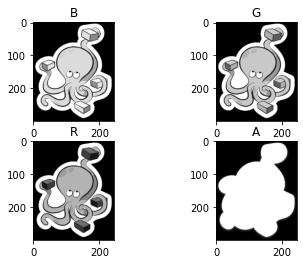

In [7]:
format = "BGRA"  # blue green red alpha
zy_img = cv2.imread("zy.png", -1)

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(zy_img[...,i], cmap = "gray")
    plt.title(format[i])

In [8]:
scene = cv2.imread("512x512_kitty.jpg")

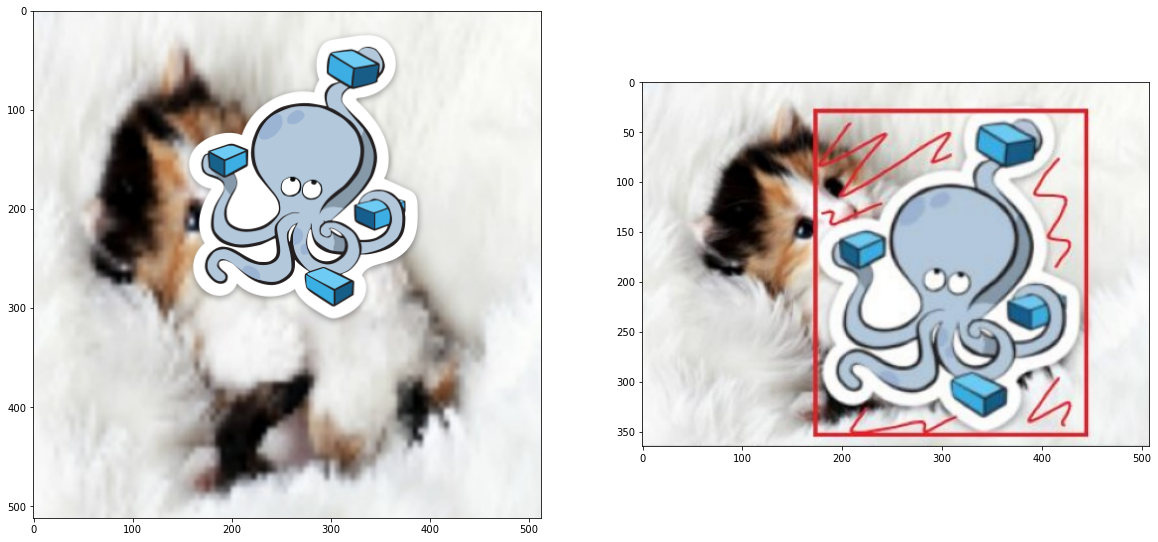

In [9]:
'''
将alpha通道归一化，从上图来看就是图案部分为1，其他部分为0。白色（1）是要， 黑色（0）不要
1 - alpha : 图案不要，背景要
'''

alpha = zy_img[...,3:] / 255 
bgr = zy_img[...,:3] 
h, w, _ = zy_img.shape
ox, oy = 150, 20  # 我们想将章鱼图放在小猫图的哪里
scene[oy:oy + h, ox : ox + w] = (scene[oy : oy + h, ox : ox + w] * ( 1 - alpha) + bgr * alpha).astype(np.uint8)
                  # bgr * alpha         ---> 章鱼取图案部分
                  # scene * (1 - alpha) ---> 小猫取非图案部分
        

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(scene[...,::-1])
plt.subplot(1,2,2)
temp = cv2.imread("paster.jpg")
plt.imshow(temp[...,::-1])

- OpenCV 读取出来的通道顺序是BGR

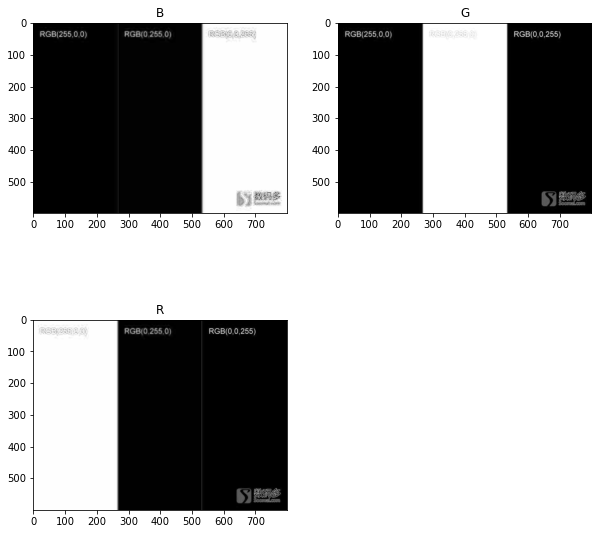

In [10]:
image = cv2.imread("rgb.jpg")
format = "BGR"
plt.figure(figsize = (10,10))
for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.imshow(image[..., i], cmap="gray")
    plt.title(format[i])

* cv2.cvtColor(src, code[, dst[, dstCn]]) -> dst
* code指定为cv2.COLOR_BGR2GRAY，则是转换bgr到灰度图
* code指定为cv2.COLOR_BGR2RGB，则是转换bgr到rgb
* 对应还有yuv等等格式[参照这里](https://docs.opencv.org/4.1.0/d8/d01/group__imgproc__color__conversions.html#ga4e0972be5de079fed4e3a10e24ef5ef0)

* 题外话，通常一个文件的前5个字节即可判断图像格式，如果按照图像格式解析，也可以简单的就读取到图像大小等信息

In [11]:
def get_im_type(flag):
    # encode a str to a bytes object.
    if flag[:2] == b"\xFF\xD8": # ref: https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal
        return "JPEG" # 返回字符串
    
    if flag[:4] == b"RIFF": # 四个字节
        return "TIFF"
    
    if flag[1:4] == b"PNG": # 三个字节
        return "PNG"
    
    if flag[:3] == b"GIF": # 三个字节
        return "GIF"
 
    print("Unknow image type: ", flag)
    return None

def get_im_type_file(file):
    with open(file, "rb") as f:
        return get_im_type(f.read(5))

In [12]:
files = ["kitty.jpg", "zy.png", "rgb.jpg"]
for file in files:
    file_type = get_im_type_file(file)
    print(f"{file} format is {file_type}")

kitty.jpg format is JPEG
zy.png format is PNG
rgb.jpg format is JPEG


# 绘图API 

- 3.draw_geometric_shape_on_image.py

* 绘制框
* cv2.rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> img

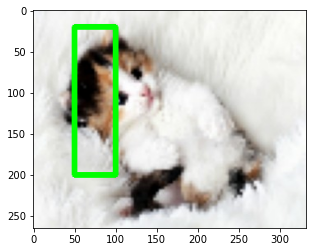

In [13]:
image = cv2.imread("kitty.jpg")
x1, y1 = (50, 20)
x2, y2 = (100, 200)
cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 5, 0)
show(image)
# 只有在 你要imshow  或者 是 imwrite 还有画图的时候才要考虑变成int ，否则整个运算过程都要是float

* 绘制圆
* cv2.circle(img, center, radius, color[, thickness[, lineType[, shift]]]) -> img
* cv2.LINE_AA(16)可以改善绘制质量（注意边缘）
* thickness为-1时是FILL填充，否则将会是空心的
* shift是缩放绘制，通过他可以更精细化的改进绘制质量

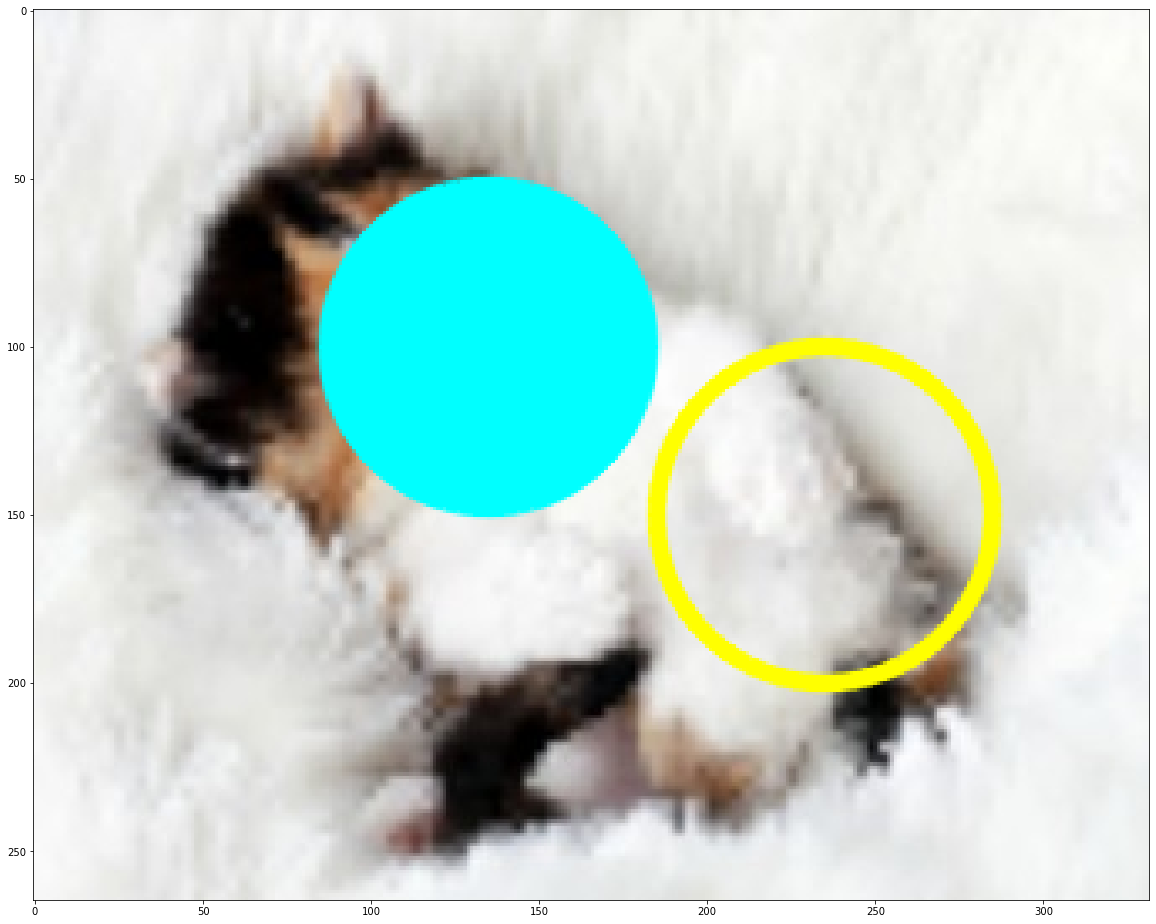

In [14]:
image = cv2.imread("kitty.jpg")
x, y = 135, 100


cv2.circle(image, (x, y), 50, (255,255,0), -1, 16, 0)
cv2.circle(image, (x+100, y+50), 50, (0, 255, 255), 3, cv2.LINE_AA)
plt.figure(figsize = (20, 20))
show(image)

* 绘制线条
* line(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> img

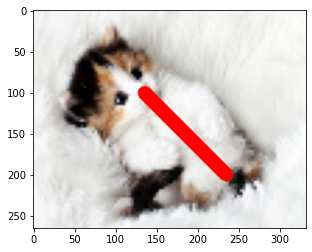

In [15]:
image = cv2.imread("kitty.jpg")
x = 135
y = 100
cv2.line(image, (x, y), (x + 100, y + 100), (0, 0, 255), 15, cv2.LINE_AA)
show(image)

# 缩放和插值

## resize

* 图像缩放
* cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst
* 可以指定dsize为新大小，也可以指定为(0, 0)，然后由fx、fy按照比例缩放作为新大小
* interpolation作为插值模式，影响图像质量

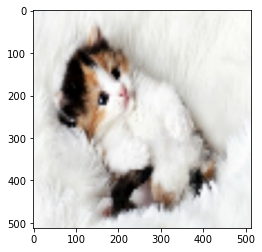

In [16]:
dst = np.zeros((512, 512, 3), dtype = np.uint8) 
img = cv2.imread("kitty.jpg")
_ = cv2.resize(img, (512, 512), dst)
plt.imshow(dst[...,::-1])

((30, 50, 3), (265, 332, 3))

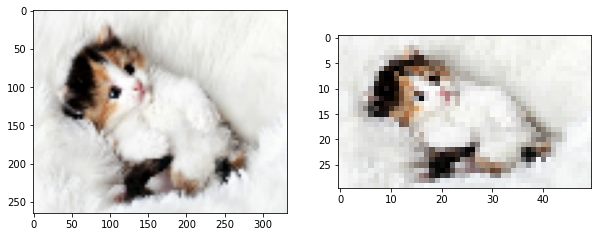

In [17]:
image = cv2.imread("kitty.jpg")
new_image = cv2.resize(image, (50, 30)) # 宽高 #!!!!!!(w, h)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
show(image)
plt.subplot(1, 2, 2)
show(new_image)
new_image.shape, image.shape

((132, 398, 3), (265, 332, 3))

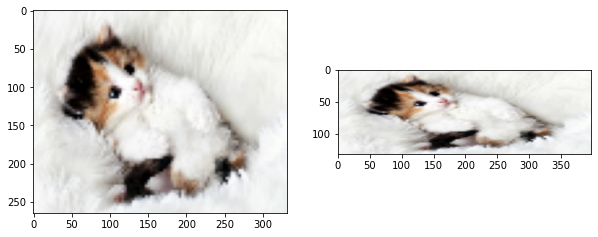

In [18]:
image = cv2.imread("kitty.jpg")
new_image = cv2.resize(image,(0,0), fx=1.2, fy=0.5)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
show(image)
plt.subplot(1, 2, 2)
show(new_image)
new_image.shape, image.shape

## interpolation

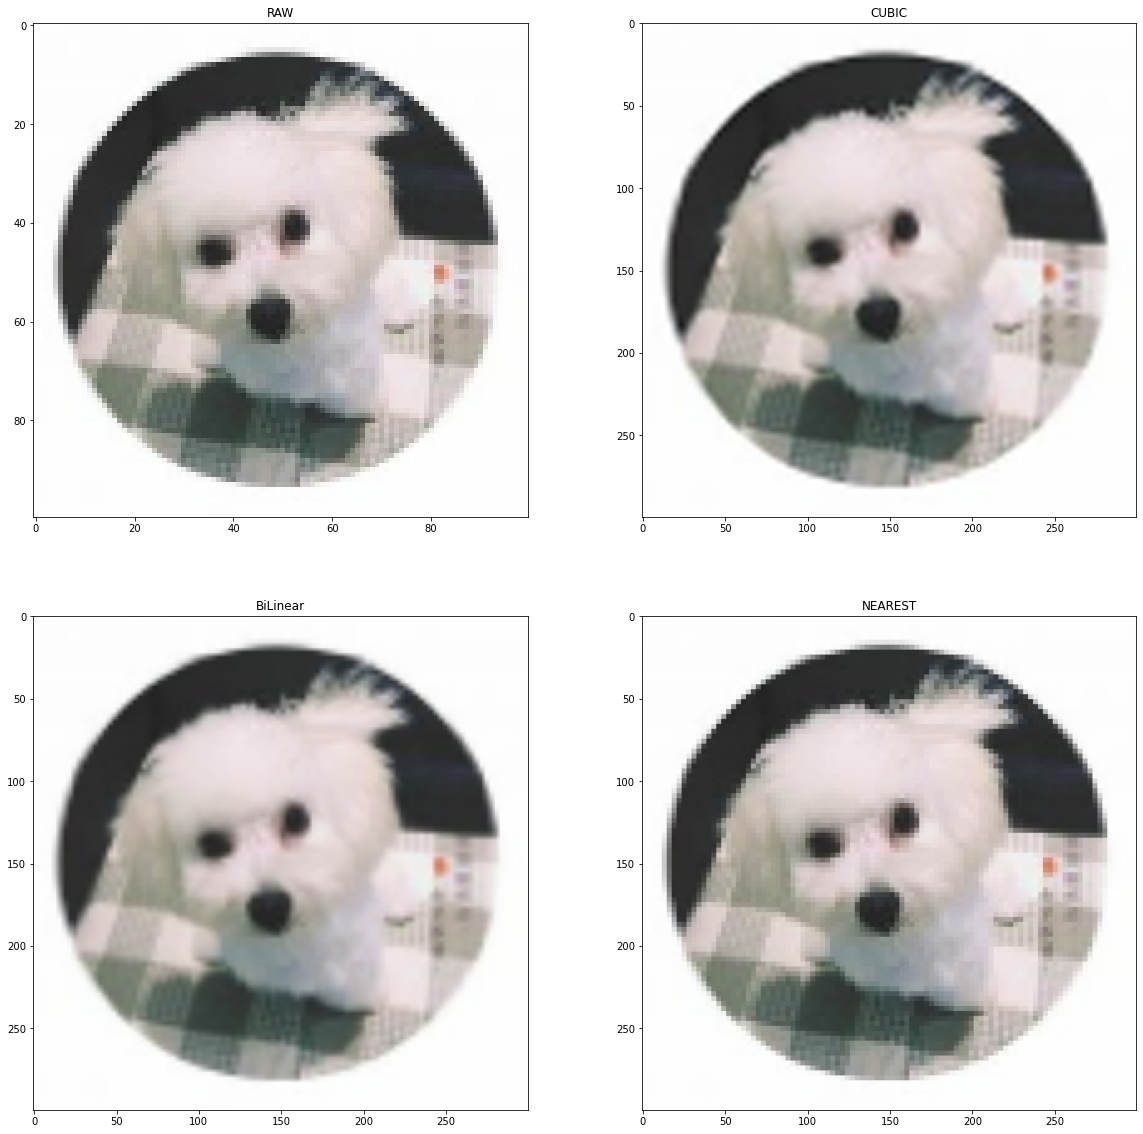

In [19]:
image = cv2.imread("dog.jpg")
image = cv2.resize(image, (100, 100))
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.title("RAW")
show(image)

# 插值方式
plt.subplot(2, 2, 2)
plt.title("CUBIC")     # 三次插值
new_image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_CUBIC)
show(new_image)

plt.subplot(2, 2, 3)
plt.title("BiLinear")  # 双线性插值
new_image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_LINEAR)
show(new_image)

plt.subplot(2, 2, 4)
plt.title("NEAREST")   # 最近邻插值
new_image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_NEAREST)
show(new_image)

### theory

- Nearest Neighbor Interpolation
    - ref: https://www.youtube.com/watch?v=8bTDssnJyZc
    - 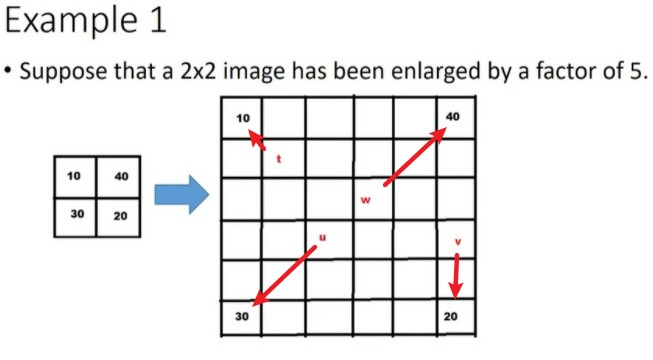

- Bilinear Interpolation
    - 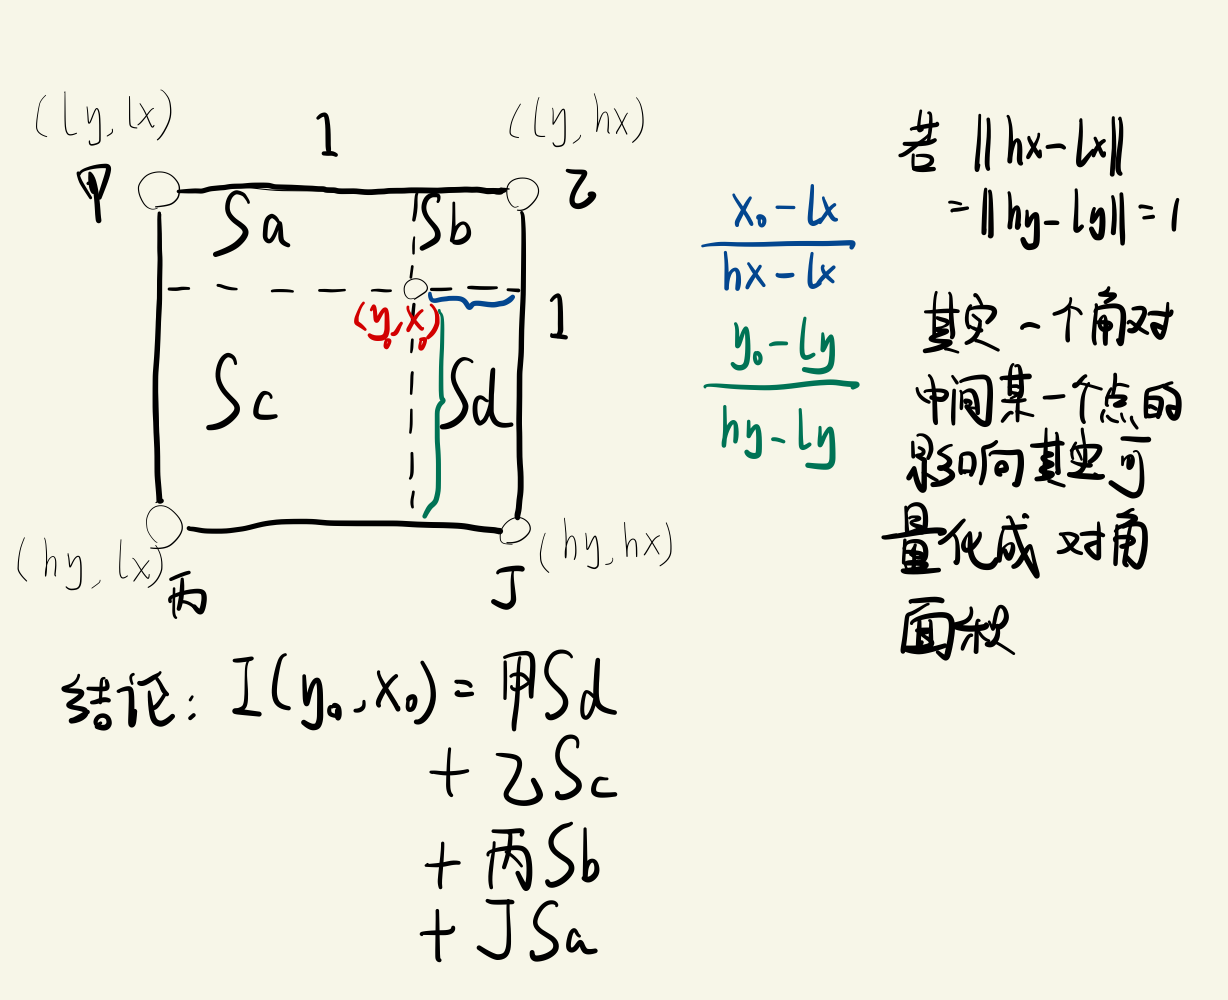

# 对图像像素的操作

## 算数操作（arithmetic operattion）
### 直接+-

uint8
204


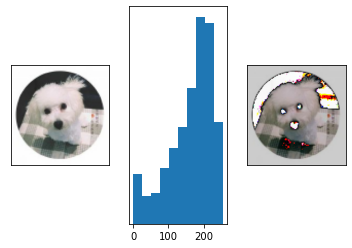

In [20]:
# 一些实验
src_dog = cv2.imread("dog.jpg")

plt.subplot(1,3,1)
plt.xticks([]), plt.yticks([])
plt.imshow(src_dog[...,::-1])

# 图像降低亮度
plt.subplot(1,3,2)
dog = src_dog - 50 #!!! 操作的时候都用float，只有最后要求显示的时候采用转回去uint8
print(dog.dtype)
plt.hist(dog.ravel())
plt.yticks([])

plt.subplot(1,3,3)
plt.xticks([]), plt.yticks([])
plt.imshow(dog[...,::-1])
print(dog[0,0,0]) # 如果你直接对图像进行 + - 操作，那么它最小为0，最大为255，逢255又回去

In [21]:
dog[0,0,0] -= 206
dog[0,0,0]

254

----运算----- float64
xxxx显示xxxxx uint8


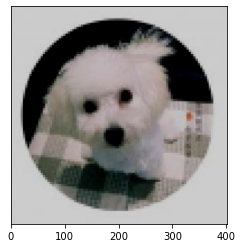

In [22]:
# 正确的做法 运算时一定要用float，要显示的是要么是float 0-1 要么是int 0-255
# 图像降低亮度  并且 裁切避免下溢 # numpy float64 表示更好的精度， 但是 torch 默认的是 float32
dog = src_dog - 50.0
print("----运算-----",dog.dtype)

dog = np.clip(dog, a_min = 0, a_max = 255).astype(np.uint8) #!!! 操作的时候都用float，只有最后要求显示的时候采用转回去uint8
print("xxxx显示xxxxx",dog.dtype)
plt.yticks([])
plt.imshow(dog[...,::-1])

### cv2.add 和 cv2.addWeighted

In [23]:
img = cv2.imread("messi.jpg")
img2 = cv2.imread("lena.jpg")

print(img.shape)
print(img.size)
print(img.dtype)

b, g, r = cv2.split(img) # 讲图片通道拆开
merged_img = cv2.merge((b,g,r))

# ball = img[228:257, 252:302]
# img[228:257, 100:150] = ball

img = cv2.resize(img, (512, 512))
img2 = cv2.resize(img2, (512, 512)) # w h 

(260, 422, 3)
329160
uint8


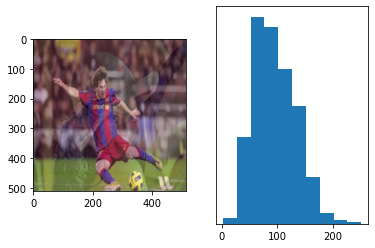

In [24]:
# dst = cv2.add(img, img2) # color is distorted
dst = cv2.addWeighted(img, 0.7, img2, 0.3, 0) # ref: https://docs.opencv.org/3.4.15/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19
plt.subplot(1,2,1)
plt.imshow(dst[...,::-1])

_ = plt.subplot(1,2,2)
_ = plt.hist(dst.ravel()) 
_ = plt.yticks([])


## 逻辑操作

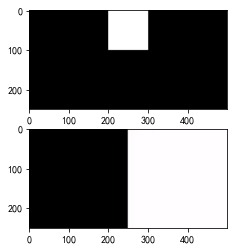

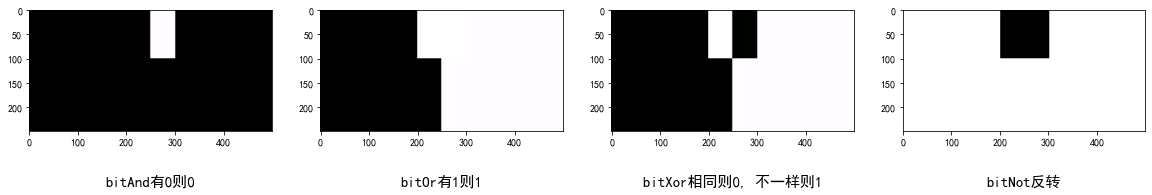

In [25]:
import cv2
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

img1 = np.zeros((250, 500, 3), np.uint8)      
img1 = cv2.rectangle(img1, (200, 0), (300, 100), (255, 255, 255), -1)
img2 = cv2.resize(cv2.imread("image2.png"), (500, 250)) # img1 and img2 should have the same shape.

bitAnd = cv2.bitwise_and(img2, img1)
bitOr  = cv2.bitwise_or(img2, img1)
bitXor = cv2.bitwise_xor(img2, img1)
bitNot = cv2.bitwise_not(img1)

srcs    =  [img1, img2]
results =  [bitAnd, bitOr, bitXor, bitNot]
titles  =  ['bitAnd', 'bitOr', 'bitXor', 'bitNot']
description = ['有0则0','有1则1','相同则0, 不一样则1','反转']

for i in range(2):
    plt.subplot(2,1, i+1)
    plt.imshow(srcs[i])

plt.figure(figsize = (20,20))
for i in range(4):
    plt.subplot(1,4, i+1)
    plt.imshow(results[i])
    plt.title(titles[i] + description[i], y = -0.5, fontdict = {'fontsize' : 15})

    

### 应用

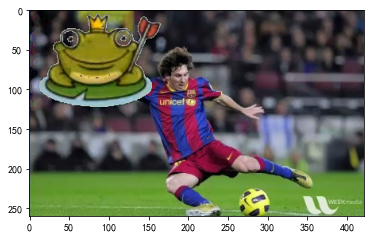

In [26]:
logo = cv2.imread("frog.jpg")
messi = cv2.imread("messi.jpg")

rows, cols, _ = logo.shape
roi = messi[0 : rows, 0 : cols] # Region of Interest

img2gray = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)


ret, mask = cv2.threshold(img2gray, 200, 255, cv2.THRESH_BINARY) # 考察查找资料的能力
mask_inv = cv2.bitwise_not(mask)

img_bg = cv2.bitwise_and(roi, logo, mask = mask )                # 拿到贴纸处所需背景
img_fg = cv2.bitwise_and(logo, logo, mask = mask_inv)            # 拿到贴纸处所需的前景（青蛙的图案）

dst = cv2.add(img_fg, img_bg)
messi[0: rows, 0:cols] = dst
plt.imshow(messi[...,::-1])

## 几何操作

### 仿射变换（affine transformation）
* cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst
* cv2.getRotationMatrix2D(center, angle, scale) -> retval 通过指定中心位置、角度和缩放系数，获取变换矩阵M
* cv2.getAffineTransform(src, dst) 则是通过指定src，和dst的3个点对，获取得到变换矩阵M，计算方式如当初我们学习的求取矩阵M

In [27]:
# 方法1 （给定中心和旋转角）
dog = cv2.imread("dog.jpg")
h, w, _ = dog.shape
M = cv2.getRotationMatrix2D((200, 200), -50, 1)

#new_point = M @ point(3行1列)   x, y, 1  # 我们当然不会一个一个点的去做这个运算

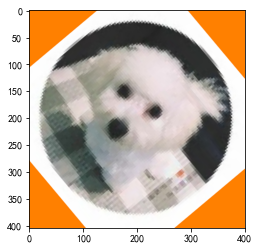

In [28]:
new_dog = cv2.warpAffine(dog, M, (w, h), flags = cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 128, 255))
show(new_dog)

In [29]:
# 方法2 （给定三个点）
dog = cv2.imread("dog.jpg")
h, w, _ = dog.shape

src = np.array([
    [0, 0], # topleft
    [w, 0], # topright
    [w, h]  # bottomright
], dtype = np.float32) # "float"

dst = np.array([
    [10, 10],
    [180, 150],
    [80, 230]
], dtype= "float32")

M = cv2.getAffineTransform(src, dst) # solvePNP # 最小二乘法
M

array([[ 0.42394015, -0.24752475, 10.        ],
       [ 0.34912718,  0.1980198 , 10.        ]])

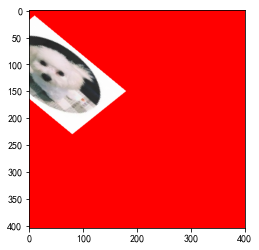

In [30]:
new_dog = cv2.warpAffine(dog, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 255))
show(new_dog)
# 仿射变换：2d平面里面，做一些变换之后，不改变其线段的平行性

### 透视变换（perspective transformation）

* cv2.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst
* cv2.getPerspectiveTransform(src, dst[, solveMethod]) -> retval   通过指定src和dst的4个点对，实现透视变换

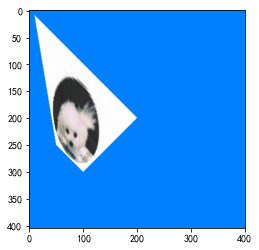

In [31]:
dog = cv2.imread("dog.jpg")
h, w, _ = dog.shape
src = np.array([
    [0, 0],
    [w, 0],
    [w, h],
    [0, h]
], dtype=np.float32)

dst = np.array([
    [10, 10], # xy
    [200, 200],
    [100, 300],
    [50, 250]
], dtype=np.float32)

M = cv2.getPerspectiveTransform(src, dst)
# borderMode可以指定边界处理方法，可以是复制边缘、填充常量等
# flags可以提供插值方式，例如cv2.INTER_CUBIC，和warp方式例如cv2.WARP_INVERSE_MAP的组合结果，组合方式直接相加，或者位或即可
# cv2.WARP_INVERSE_MAP可以对M进行反变换
new_dog = cv2.warpPerspective(dog, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 128, 0))
show(new_dog)

# 传统方法里面，车道线检测

### theory
- details of image transformation.ipynb

<!-- # code binlinear interpolation from scratch -->

In [32]:
import cv2
import numpy as np

image = cv2.imread("./hxw_176x250.jpg")
resized = cv2.resize(image, (0,0), fx = 1.5, fy = 1.5)

src_h, src_w = image.shape[:2]
dst_h, dst_w = resized.shape[:2]

dst = np.zeros((dst_h, dst_w, 3), dtype = np.uint8)

M = np.array([
    [1.5, 0,   0],
    [0,   1.5, 0]
])

invert_M = cv2.invertAffineTransform(M)
const_value = 114
invert_M

array([[ 0.66666667, -0.        ,  0.        ],
       [-0.        ,  0.66666667,  0.        ]])

In [33]:
for dy in range(dst_h):
    for dx in range(dst_w):
        ix, iy = invert_M @ np.array([dx, dy, 1]).reshape(3, 1) + np.array([0.5, 0.5, 1]).T
        
 
        # p0     p1
        # 
        # p2     p3
        if(ix <= -1 or ix >= src_width or src_y <= -1 or src_y >= src_height): #
            dst[dy, dx, :] = const_value
        else:
            # 开始双线性插值 获取离ix, iy 最近的4个像素并插值
            ix_low = np.floor(ix)
            ix_high = ix_low + 1

            iy_low = np.floor(iy)
            iy_high = iy_low + 1
            
            ly = iy - iy_low
            lx = ix - ix_low
            hy = 1 - ly
            hx = 1 - lx
            
            w1, w2, w3, w4 = hy * hx, hy * lx, ly * hx, ly * lx
            
            v1, v2, v3, v4 = const_value
            if (iy_low >= 0): 
                if (ix_low >= 0):
                    v1 = image[iy_low, ix_low]
                
                if (ix_high < src_w):
                    v2 = image[iy_low, ix_high]
            
            if (iy_high < src_h):
                if (ix_low >= 0):
                    v3 = image[iy_high, ix_low]
                if (ix_high < src_w):
                    v4 = image[iy_high, ix_high]
            
            
            p = w1 * v1 + w2 * v2 + w3 * v3 + w4 * v4
            dst[dy, dx, :] = p
           
        

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
int(-0.1), int(0.1), int(254.1), int(255.1)
import math
math.floor(-0.7),math.floor(0.1), math.floor(254.1), math.floor(255.7)

# 滤波与卷积(filter and convolution)

In [ ]:
image = cv2.imread("dog.jpg")

plt.figure(figsize=(10, 10))
plt.subplot(2, 3, 1)
plt.title("GaussianBlur")
new_image = cv2.GaussianBlur(image, (15, 15), 5)
show(new_image)

plt.subplot(2, 3, 2)
plt.title("medianBlur")
new_image = cv2.medianBlur(image, 15)
show(new_image)

plt.subplot(2, 3, 3)
plt.title("boxFilter") # https://en.wikipedia.org/wiki/Box_blur
new_image = cv2.blur(image, (15, 15))
show(new_image)

plt.subplot(2, 3, 4)
plt.title("filter2D")
kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
], dtype=np.float32)
new_image = cv2.filter2D(image, ddepth=cv2.CV_8U, kernel=kernel)
show(new_image)

plt.subplot(2, 3, 5)
plt.title("canny")
new_image = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 50, 200)
show(new_image)

小总结：卷积的作用
- 提取信息
- 检测模式
- 噪点去除

# 边缘检测（edge detection）

<b>为什么需要边缘检测?<b>
- 去除掉大部分没有用的信息

<b>Edge Detection的方法<b>
- differential method (微分法）
- template method （模板法）
- optimization method （优化法）
    
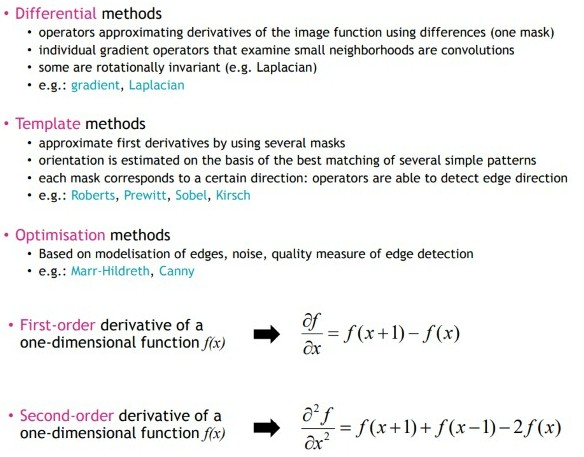


<b>什么是Edge?<b>
<br>
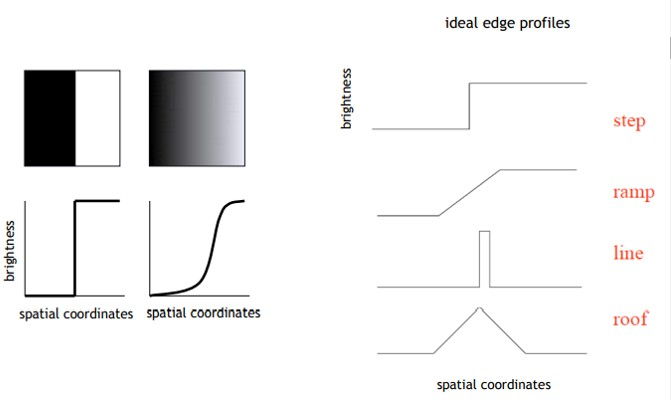

<b>用导数去判断Edge的存在<b><br>
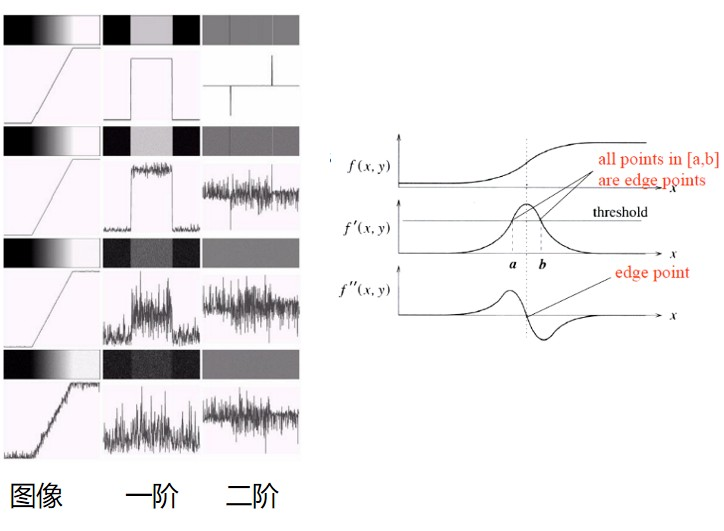

二阶的优点和缺点（为后面埋下伏笔）
 - 优点：两个极值点之间必有edge point，所以容易操作
 - 缺点：对噪声很敏感

## Differential method
- 通过对一阶导的近似，在离散空间上，我们可以基于central difference 来设计出下面第一行的两种算子
- 通过对二阶导的近似，在离散空间上，我们可以基于central difference 来设计出下面第二行的两种算子


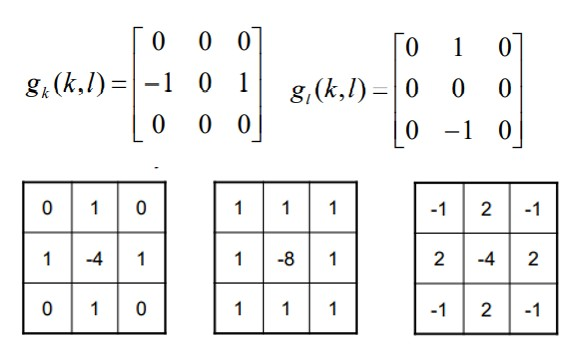




## Template method
- 基于微分法再设计出一些模板<br>
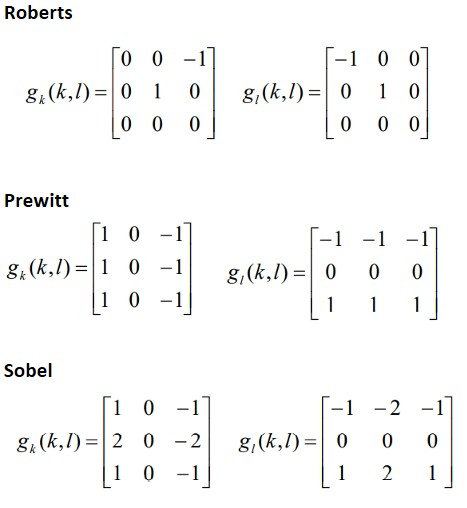

## Otimization method
- Canny 算子
- 基于比较优秀的模板，增加其他前处理和后处理进行优化（步骤如下）
    - 高斯平滑去噪
    - 边缘检测
    - NMS去除多余edge响应 non-maximum-suppression
    - double thesholding
    - 去除不连接强边缘的弱边缘
    
- 实现细节: 
    - https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?gi=ba77f6458e0d
    

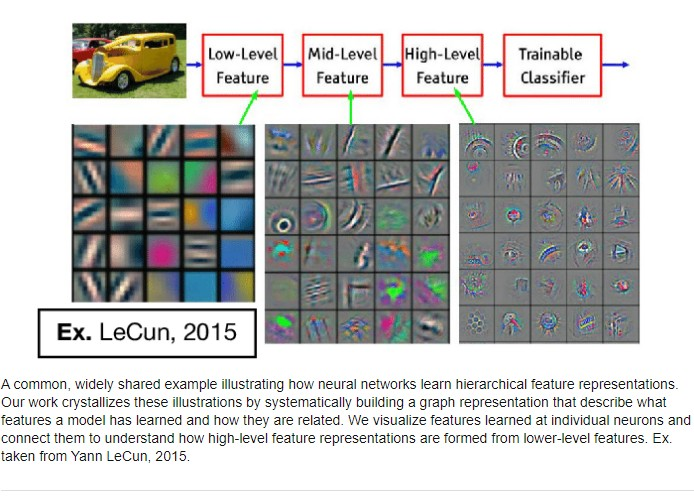
- https://www.researchgate.net/figure/A-common-widely-shared-example-illustrating-how-neural-networks-learn-hierarchical_fig1_335360163

# 特征点（feature points）
应用领域：
- 图像拼接（Matching）
- 目标跟踪（tracking of objects）
- 机器人导航（robot navigation）
- 目标识别（object recognition）
- 姿态估计&相机标定（pose estimation & camera calibartion）
- 场景分类（scene classification)
- 纹理分类（texture classification）
- 图片索引和查询（image indexing and retrieval）
- 视频挖掘（video mining）
- 增强现实（augmented reality）
- 人脸对齐（face alignment）# traditional method

In [ ]:
image_name = ['image_matching.jpg', 'image_matching_harder_case.jpg', 'panorama_stitching.jpg', 'NASA_image_matching.jpg', 'interest_point_matching.jpg']

plt.figure(figsize=(40,40))
for i in range(len(image_name)):
    img = cv2.imread(image_name[i])
    plt.subplot(len(image_name), 1, i + 1)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

- 疑问：既然深度学习那么火，为什么我们还要了解SIFT等传统算法呢？
- https://www.zhihu.com/question/48315686

## 情景

变形（Deformations）
- 比较下面的两张图I1和I2，I2是I1变换后的结果
- 结果可能会遇到以下变形<br>
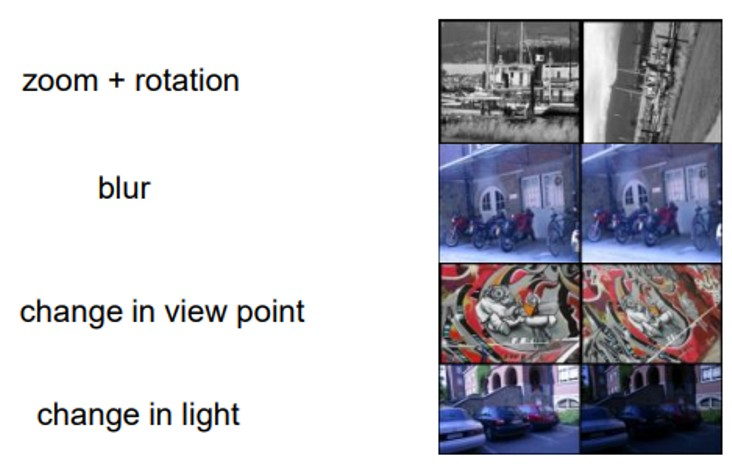


## 定义good feature<br>
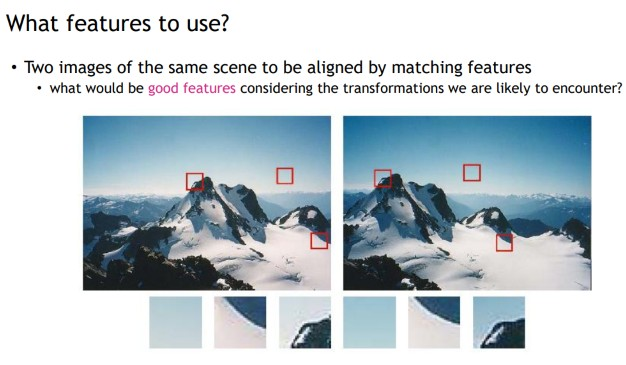

- 一些简单的特征描述（很古老的很朴素的）
    - 像素值的list
    - 颜色直方图
 
- 一个good feature 反应的是某一块图的模式应该与它周围的不一样，local feature也可以理解成描述子（descriptor）
    - 可重复性（repeatability）
    - 显著性（distinctiveness）
    - 局部性（locality）
    - 数量多（quantity）
    - 够准确（accuracy）
    - 够高效（effiency）
    
- 经过各种探索，我们发现corner是一个很好的local feature
    - 接下来 point feature/ interest points/ corners/ feature points 暂时理解为就是同一个概念
   


## 找interest point的方法
- variance-based interest operator （基于像素值变化的）
    - Moravec
    - 给定一个像素，给定一个以该像素为中心的小窗，移动小窗，看看移动之后在各个方向都发生的变化很大的就是feature point
- derivatives-based operator (基于像素的梯度变化)
    - e.g. harris
    - 给定一个像素，对像素进行微小的位置偏移（微分)，通过分析梯度矩阵的特征值和特征向量来判断该点是平面/边缘/角/点
    - taylor-series （这里我们一般只是展开到一阶）
        - 两个特征值都小的是平面
        - 两个特征值一大一小是边缘
        - 两个特征值都大的是点或者角

- scale-space approach (加入了尺度空间的变化)
    - 不断的高斯模糊图片，使得我们在各种模糊尺度里面都能够提取到该尺度下的特征点
    
    



   

## Harris Corner Detector
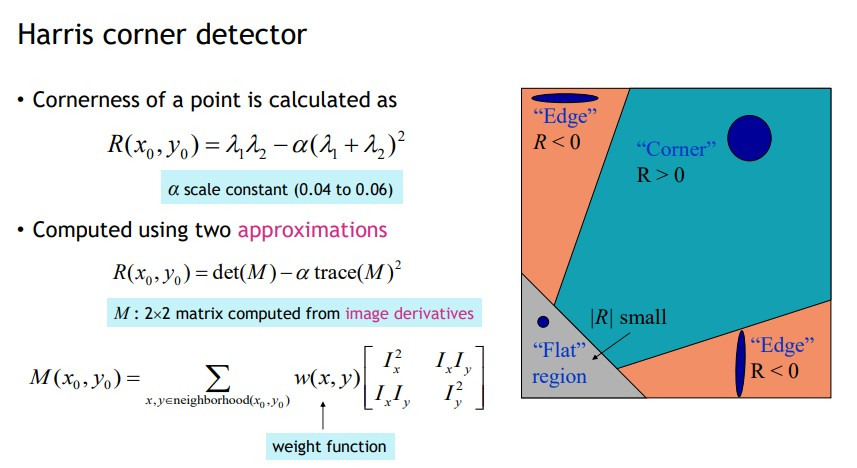
- 使用：
    - https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

- 理论
    - 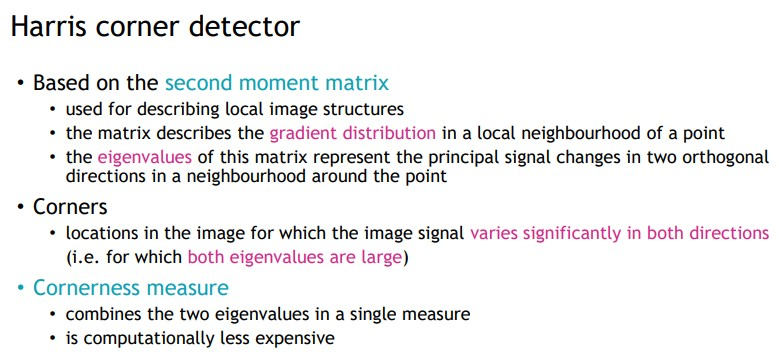

## SIFT(scale invariant feature transform)
- 尺度不变性变换
- 主要步骤：
    - 尺度空间下的极值检测
    - 关键点定位
    - 赋方向
    - 关键点描述子

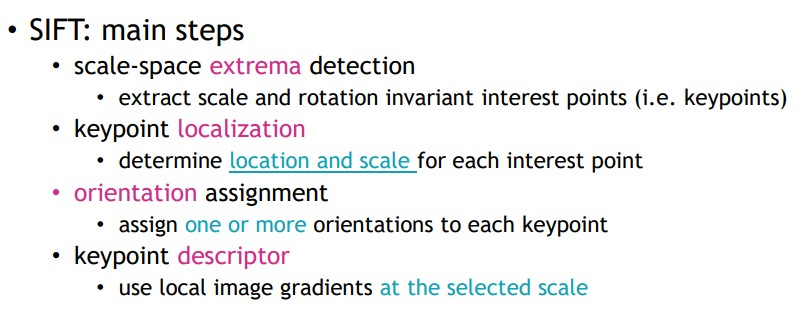

- 具体请看
    - slide / lecture notes
    - C:/Users/PeterHuang/Desktop/courses/ComputerVision/06_ICV_FeaturePoints.pdf
- ref: 
    - recommended: https://www.bilibili.com/video/BV1Qb411W7cK?p=4&spm_id_from=pageDriver
    - https://courses.cs.washington.edu/courses/cse576/06sp/notes/Interest2.pdf
    - https://www.vlfeat.org/overview/sift.html 看图

- 关键点：
    - DoG 高斯之差 它跟laplacian 很像 ref: https://paperswithcode.com/method/laplacian-pyramid
    - 关键点过滤(keypoint filtering) 回忆harris
    - 每个关键点（我们知道了亚尺度sub-scale）都有大小和方向, 但是真正的大小和方向都在较近的scale尺度上进行计算
        - 对每个关键点, 我们对它的附近(结合尺度来定附近范围的大小)都进行梯度计算，建立一个起一个histogram of gradient directions
        - 通过这个histogram of gradient directions, 我们可以统计出最具有代表性的方向和副方向（如果有）
        - 为了实现旋转不变性
    - 描述子的构建
        - 4 x 4 区域，每块区域 4 x 4 个像素。每块区域去统计8个方向的histogram
        - 所以 16 x 8 = 128

    - 特征对比：
        - KNN


# 相机标定（camera calibration）

- （比较学术的说法）为什么需要相机标定
    - 计算机视觉的关键任务之一是从二维图像中恢复场景的三维结构。 我们想一下。 你有一个在世界坐标系中定义的场景。你想知道场景上的每一个点是处在世界坐标系中的哪个位置（越精确越好），但是我们其实只有一张2d的图片，而且图片上的点都是以像素为单位的（离散的），而且图片是会发生变形的。所以为了从有形变的离散像素重构到完美连续重构(full metric reconstruction）。我们需要两件东西：
    - 1.相机坐标（相对于世界坐标）和朝向   (position and orientation)  # external parameter of the camera
    - 2.相机是怎么将世界坐标点映射到2d图片上的 # internal parameter of the camera e.g. focal lens
 
 相机标定：计算出相机的外部参数和内部参数
 
 
 - （比较工程的说法）
     - 相机是不完美的，拍出来的图像会变形，我们想将变形的图像恢复到不变形。

# TO DO LIST
- 详细讲解affine transformation
- 写完edge detection 和feature point的教案
- src/tensorRT/common/preprocess_kernel.cu  C++ warpaffine
- STN DCN ROIpooling  ROIAlign
- Remap https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/page_tutorial_remap.html
- SIFT https://courses.cs.washington.edu/courses/cse576/06sp/notes/Interest2.pdf  使用
- ORB
- solvePNP https://docs.opencv.org/4.5.3/d9/d0c/group__calib3d.html
- camera calibration https://learnopencv.com/camera-calibration-using-opencv/
- Harris Corner 使用
- Canny https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123?gi=ba77f6458e0d